In [9]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../flood_prediction') # going to the parent folder of the current folder
from data_prep import get_data_and_targets

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf

# Getting data from API (data_prep.py)

In [2]:
df = get_data_and_targets()

In [5]:
df.shape

(347685, 10)

In [35]:
df.tail(5)

,T(degC),rain(mm),surf_press(hPa),wind_s(km/h),wind_dir(deg),soil_moist_0_to_7cm(m3),soil_moist_7_to_28cm(m3),radiation(W/m2),river_discharge(m3/s)
date,,,,,,,,,
2023-08-30 16:00:00,18.1,0.0,988.1,13.0,194.0,0.420,0.437,683.0,49.58
2023-08-30 17:00:00,17.9,0.0,987.2,12.6,193.0,0.419,0.436,532.0,49.58
2023-08-30 18:00:00,17.3,0.0,987.1,11.3,197.0,0.418,0.436,318.0,49.58
2023-08-30 19:00:00,16.0,0.0,986.4,8.9,201.0,0.418,0.436,136.0,49.58
2023-08-30 20:00:00,13.9,0.0,986.1,8.6,195.0,0.418,0.436,7.0,49.58


In [7]:
df.drop(columns='target', inplace=True)
df.shape

(347685, 9)

# Defining goblal variables of the data set

In [13]:
TARGET = 'river_discharge(m3/s)'
N_TARGETS = 1
N_FEATURES = 8

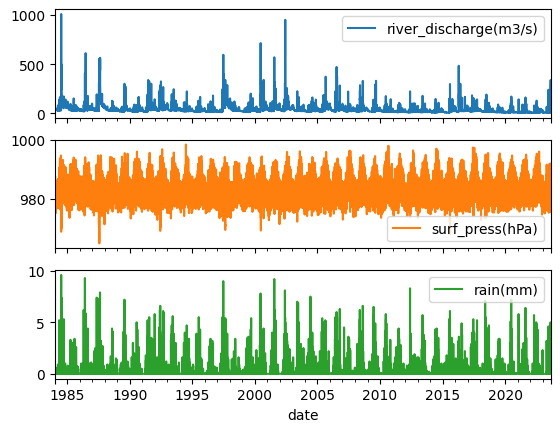

In [14]:
plot_cols = [TARGET, 'surf_press(hPa)', 'rain(mm)']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

In [16]:
DATA = dict(
    length = 347685, # How many timesteps does your dataset contains?
    n_covariates = 8, # number of past covariates, excluding target time series. Our tests do not support future_covariate yet.
    target_column_idx = [0] # List of index(es) of target column(s) in your dataset. e.g [0] for Mono-target problem, e.g. [0,1,4] for multi-variate targets problem. Note that past targets values will also be used as features X.
)

# Creating Folds

### Defining global variables

In [17]:
# Considering folds of 1 year
FOLD_LENGTH = 24 * 365

# Folds starting every trimester
FOLD_STRIDE = 24 * 91  # 1 quarter = 91 days

# train-test-split ratio of 2/3 
TRAIN_TEST_RATIO = 0.66

### Function to get folds

In [19]:

def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
    """    
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Args:
        df (pd.DataFrame): Overall dataframe
        fold_length (int): How long each fold should be in rows
        fold_stride (int): How many timesteps to move forward between taking each fold

    Returns:
        List[pd.DataFrame]: A list where each fold is a dataframe within
    """
    # $CHALLENGIFY_BEGIN
    
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

In [21]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 156 folds.
Each fold has a shape equal to (8760, 9).


In [24]:
fold = folds[0]
fold

,T(degC),rain(mm),surf_press(hPa),wind_s(km/h),wind_dir(deg),soil_moist_0_to_7cm(m3),soil_moist_7_to_28cm(m3),radiation(W/m2),river_discharge(m3/s)
date,,,,,,,,,
1984-01-01 00:00:00,19.2,0.0,982.1,4.5,331.0,0.251,0.278,0.0,48.77
1984-01-01 01:00:00,19.1,0.0,981.9,4.5,331.0,0.251,0.278,0.0,48.77
1984-01-01 02:00:00,18.6,0.0,982.0,4.1,345.0,0.251,0.278,0.0,48.77
1984-01-01 03:00:00,18.2,0.0,981.9,3.6,6.0,0.251,0.278,0.0,48.77
1984-01-01 04:00:00,17.7,0.0,981.9,3.7,11.0,0.251,0.278,0.0,48.77
...,...,...,...,...,...,...,...,...,...
1984-12-30 19:00:00,24.9,0.0,980.7,13.8,242.0,0.258,0.279,460.0,85.30
1984-12-30 20:00:00,23.3,0.0,980.6,10.8,244.0,0.258,0.279,247.0,85.30
1984-12-30 21:00:00,21.5,0.0,980.8,5.7,252.0,0.258,0.279,55.0,85.30


# Train/Test split in the fold

### Defining global variables

In [97]:
# Input lenght of 1 week
INPUT_LENGTH = 24 * 7

### Defining train/test split function

In [53]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
    """From a fold dataframe, take a train dataframe and test dataframe based on 
    the split ratio.
    - df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    - df_test should contain all the timesteps needed to create all (X_test, y_test) tuples

    Args:
        fold (pd.DataFrame): A fold of timesteps
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (fold_train, fold_test)
    """
    
    # TRAIN SET
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]
    

    return (fold_train, fold_test)

### Defining fold train and fold test inside fold

In [98]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [99]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH/24)} days')

N_FEATURES = 8
INPUT_LENGTH = 168 timesteps = 7 days


In [91]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')
# we predict only one value ahead of us (1 hour ahead)
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


# Create (X, y) insise each 'split' by random sampling

### Get one sample (Xi, yi)

In [54]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int) -> tuple[pd.DataFrame]:
    """given a fold, it returns one sequence (X_i, y_i) as based on the desired 
    input_length and output_length with the starting point of the sequence being chosen at random based

    Args:
        fold (pd.DataFrame): A single fold
        input_length (int): How long each X_i should be 
        output_length (int): How long each y_i should be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (X_i, y_i)
    """
    
    if fold.isnull().values.any():
        raise ValueError('fold contains NaN values')

    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)

### Get (X, y) from multiple samples

In [55]:
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int) -> tuple[np.array]:
    """Given a fold generate X and y based on the number of desired sequences 
    of the given input_length and output_length

    Args:
        fold (pd.DataFrame): Fold dataframe
        number_of_sequences (int): The number of X_i and y_i pairs to include
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y):
            X.shape = (n_samples, input_length, n_covariates)
            y.shape =
                (n_samples, output_length, n_targets) if all 3-dimensions are of size > 1
                (n_samples, output_length) if n_targets == 1
                (n_samples, n_targets) if output_length == 1
                (n_samples, ) if both n_targets and lenghts == 1   
    """
  
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

In [105]:
fold.shape

(8760, 9)

In [104]:
# Choosing randomly the number of samples
N_TRAIN = 666 # number_of_samples_train
N_TEST =  333 # number_of_samples_test

In [106]:
X_train_rand, y_train_rand = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_rand, y_test_rand = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

In [107]:
print(X_train_rand.shape)
print(y_train_rand.shape)

(666, 168, 9)
(666, 1, 1)


# Create (X, y) insise each 'split' by scanning  chronologically 

### Defining the "sequence_stride"

In [68]:
# "sequence_stride" = how many timestamps in the future you move between one sample and the other
SEQUENCE_STRIDE = 24

In [69]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, 
    sequence_stride: int) -> tuple[np.array]:
    """slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence

    Args:
        fold (pd.DataFrame): One single fold dataframe
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i
        sequence_stride (int): How many timesteps to take before taking the next X_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return (np.array(X), np.array(y))

In [70]:
print("FOLD_LENGTH") 
print(f"= {FOLD_LENGTH} timesteps")
print(f"= {int(FOLD_LENGTH/24)} days")
print(f"= {int(FOLD_LENGTH/24/7)} weeks")

FOLD_LENGTH
= 8760 timesteps
= 365 days
= 52 weeks


In [79]:
X_train_ch, y_train_ch = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test_ch, y_test_ch = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train_ch.shape)
print(y_train_ch.shape)

(5613, 168, 9)
(5613, 1, 1)


# Modeling

In [72]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization

def init_model(X_train, y_train):
    
    # Normalization
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # RNN architecture 
    model = models.Sequential()
    
    ## All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    ## Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # Compiler 
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

In [81]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [82]:
from tensorflow import keras
from keras.callbacks import EarlyStopping

def fit_model(model: tf.keras.Model, verbose=1) -> tuple[tf.keras.Model, dict]:

 
    es = EarlyStopping(monitor = "val_loss",
                      patience = 3,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

### Initialising the RNN model

In [108]:
# Initialising the RNN model

model = init_model(X_train_rand, y_train_rand)
model.summary()

# Training
model, history = fit_model(model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, None, 9)          19        
 ion)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 64)                18944     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,028
Trainable params: 19,009
Non-trainable params: 19
_________________________________________________________________
Epoch 1/50
123/123 [==============================] - 5s 35ms/step - loss: 648.1627 - mae: 15.3892 - val_loss: 42632.9922 - val_mae: 144.9187
Epoch 2/50
123/123 [==============================] - 4s 33ms/step - loss: 522.2888 - mae: 13.0538 - val_

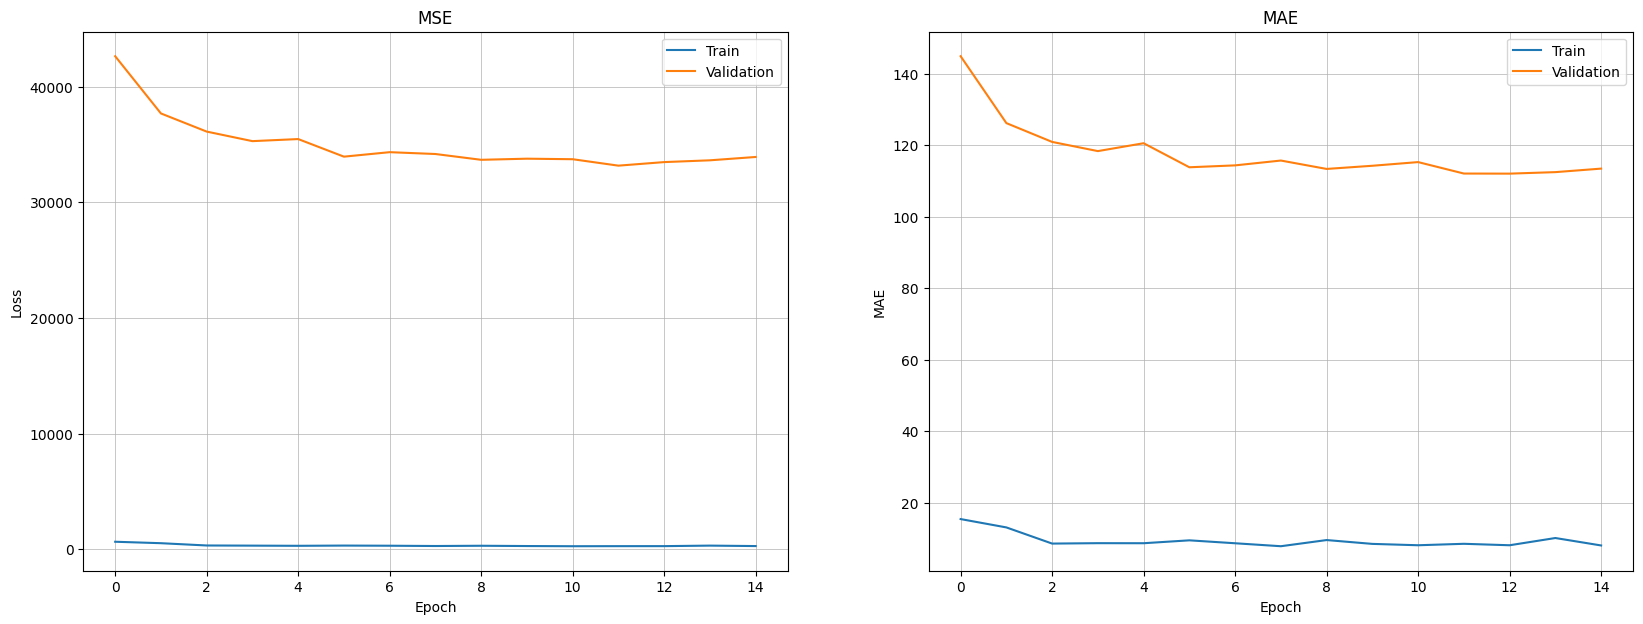

In [109]:
plot_history(history);